## First principles (pt 1): Fitting a mixture model to the 'true' data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 

import pandas as pd
import pystan

npts = 2000

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

Lets build our synthetic population no. 1

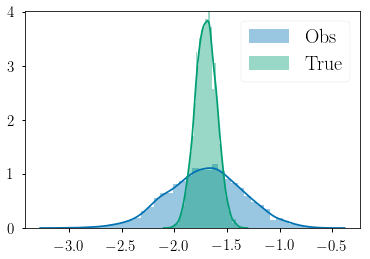

In [2]:
rQ = .95
rmu = -1.7
rsigma = .1
runc = 0.2

iM_true = np.random.randn(int(npts*rQ)) * rsigma + rmu
iunc = np.abs(runc * iM_true)
iM_obs = iM_true + np.random.randn(int(npts*rQ))*iunc

sns.distplot(iM_obs, label='Obs')
sns.distplot(iM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now synthetic population no. 2

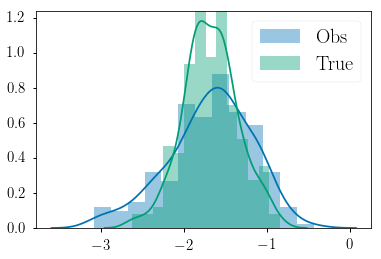

In [3]:
rmuo = rmu
rsigo = .35

oM_true = np.random.randn(int((1-rQ)*npts)) * rsigo + rmuo
ounc = np.abs(runc * oM_true) #uncertainties
oM_obs = oM_true + np.random.randn(int((1-rQ)*npts))*ounc

sns.distplot(oM_obs, label='Obs')
sns.distplot(oM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now lets combine them!

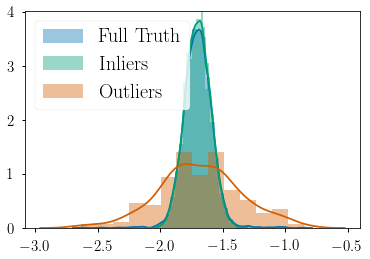

In [4]:
M_true = np.append(oM_true, iM_true)
sns.distplot(M_true, label='Full Truth')
sns.distplot(iM_true, label='Inliers')
sns.distplot(oM_true, label='Outliers')
plt.legend(fontsize=20)
plt.show()

Now I want to take M_obs and M_unc alone, and recover the 5 parameters (and maybe even the true magnitudes)

In [5]:
first1 = '''
data{
    int<lower=0> N;
    real M[N];
}
parameters {
    real mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> Q;
    real<lower=0.3> sigo;
}
model{
    mu ~ uniform(-1.9, -1.5);  //p(theta)
    sigma ~ uniform(0., 3.);   //''
    sigo ~ uniform(.3, 3.);    //''
    Q ~ uniform(0., 1.);       //''
    
    //p(D | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(M[n] | mu, sigma),
                    normal_lpdf(M[n] | mu, sigo));                    
}    
'''
sm = pystan.StanModel(model_code=first1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63a6428fb03abf6054b797b2568a50ac NOW.


In [6]:
data = {'N': len(M_true),
       'M': M_true}
fit = sm.sampling(data=data, iter=2000, chains=2)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


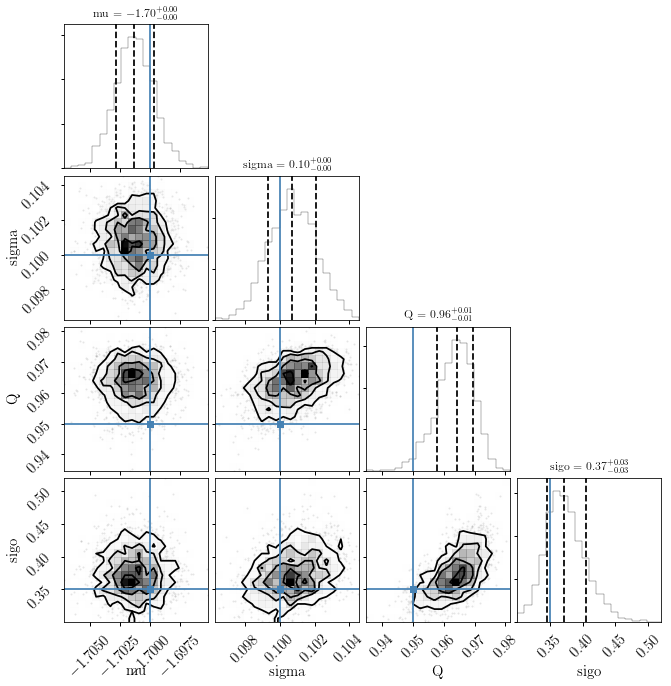

In [7]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsigma, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

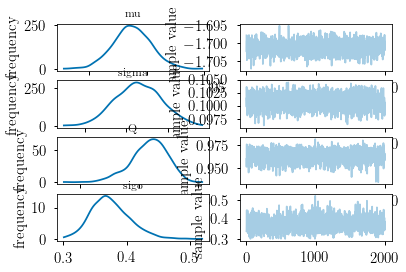

In [8]:
fit.plot()
plt.show()

In [9]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = mu
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])

fg = normal(M_true, mu, sigma)
bg = normal(M_true, mu, sigo)
L = Q*fg + (1-Q)*bg

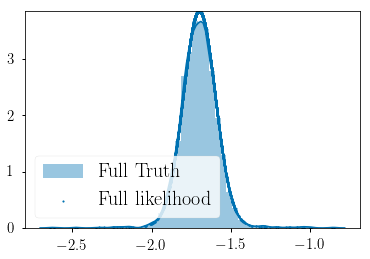

In [10]:
fig = plt.figure()
sns.distplot(M_true, label='Full Truth')
plt.scatter(M_true, L, label='Full likelihood', s=3)
plt.legend(fontsize=20)
plt.show()

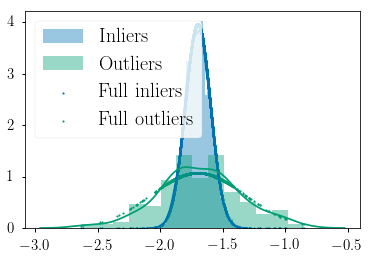

In [11]:
fig = plt.figure()
sns.distplot(iM_true, label='Inliers')
plt.scatter(M_true, fg, label='Full inliers',s=3)
sns.distplot(oM_true, label='Outliers')
plt.scatter(M_true, bg, label='Full outliers',s=3)
plt.legend(fontsize=20)
plt.show()

## First Principles (ii): A hierarchical fit to a singleinlier population

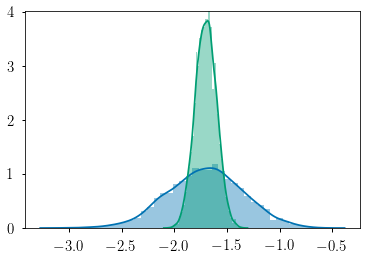

In [12]:
fig = plt.figure()
sns.distplot(iM_obs, label='Observed inliers')
sns.distplot(iM_true, label='Underlying truth')
plt.show()

In [13]:
first2 = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    real mu;
    real<lower=0> sigma;
    
    real Mtrue_std[N];
}
transformed parameters {
    real Mtrue[N];
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma*Mtrue_std[n];
    }
}
model{
    mu ~ uniform(-1.9, -1.5);  //p(theta)
    sigma ~ uniform(0., 3.);   //''
    
    Mobs ~ normal(Mtrue, Munc); //p(D | theta, alpha)
    
    //p(alpha | theta)
    Mtrue_std ~ normal(0, 1);                  
}    
'''
sm = pystan.StanModel(model_code=first2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a48fd0f0dcee6df5881e76a77b88c8f8 NOW.


In [14]:
data = {'N': len(iM_obs),
       'Mobs': iM_obs,
       'Munc' : iunc}
fit = sm.sampling(data=data, iter=2000, chains=2)

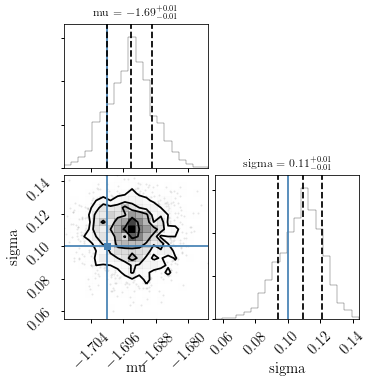

In [15]:
import corner
chain = np.array([fit['mu'],fit['sigma']]).T
truths=[rmu, rsigma]
corner.corner(chain,labels=['mu','sigma'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

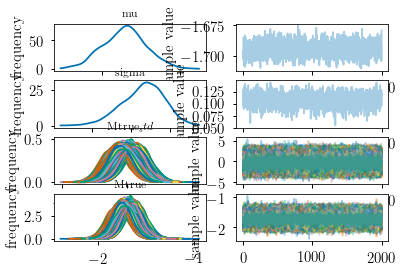

In [16]:
fit.plot()
plt.show()

In [17]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
infdM_true = np.median(fit['Mtrue'],axis=0)

x = np.linspace(iM_obs.min(), iM_obs.max(),1000)
fg = normal(x, mu, sigma)
rfg = normal(x, rmu, rsigma)

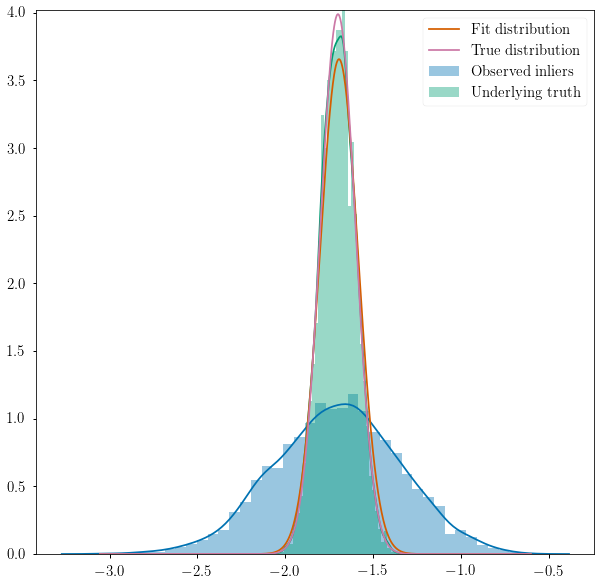

In [18]:
fig = plt.figure(figsize=(10,10))
sns.distplot(iM_obs, label='Observed inliers')
sns.distplot(iM_true, label='Underlying truth')
plt.plot(x, fg, label='Fit distribution')
plt.plot(x, rfg, label='True distribution')
plt.legend(fontsize=15)
plt.show()